# Around Local Volatility

We offer you the following practical task on local volatility model. You have **1 week** from the moment you receive this task.

If you have any questions feel free to ask in Telegram https://t.me/v_antipov. 

**Full name:** Safonova Elizaveta.

In [1]:
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
from tqdm import tqdm
import scipy.stats as st
from scipy.stats import norm
from collections.abc import Callable
from tqdm.auto import trange
import warnings
warnings.filterwarnings('ignore')
from scipy.interpolate import *
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle')

In [2]:
font = {'family':'Times New Roman', 'size': 10}
matplotlib.rc('font', **font)

---

Here you need to implement the Monte-Carlo pricing in Local Volatility model, which can be described by the following SDE (assume zero interest rates)

$$dS_t =S_t \sigma(t, S_t) dW_t, \quad S_0 = s,$$

For that purpose, you can use the standrad *Euler* discretization scheme:

$$S_{t_{i + 1}} = S_{t_i} + \sigma_{Dup}(t_i, S_{t_i}) \Delta W_{t_i}.$$

However, direct usage of such scheme may lead to negative values of the prices $S_t$. For that reason, you may apply the Euler scheme to $\log(S_{t_i})$ and then finally put $S_{t_i} = e^{X_{t_i}}$. From Ito's formula, 

$$X_{t_{i + 1}} = X_{t_i} - \frac{1}{2} \sigma^2_{Dup}(t_i, e^{X_{t_i}}) \Delta t_i+ \sigma_{Dup}(t_i, e^{X_{t_i}}) \Delta W_{t_i}.$$

Notice that for correct implementation, you need a full Dupire volatility surface function. For that reason, you should construct a properly inter-and-extrapolated function $(t, s) \to \sigma_{IV}(t, s)$, obtained from real-market data. Then you may use the well-known formula converting the observed implied volatilites $\sigma_{IV}(t, s)$ to Dupire local volatilies $\sigma_{Dup}(t, s)$: 

$$ \sigma_{Dup}(T, K) = \sqrt{\dfrac{\frac{\partial w}{\partial T}}{1 - \frac{y}{w} \frac{\partial w}{\partial y} + \frac{1}{4} ( -\frac{1}{4} - \frac{1}{w} + \frac{y^2}{w^2}) (\frac{\partial w}{\partial y})^2 + \frac{1}{2} \frac{\partial^2 w}{\partial y^2}}},$$


where 
$w(K, T) = \sigma^{2}_{IV}(K, T) \cdot T$ is implied variance and $y = \log(K / F_T)$ is forward log-moneyness. 

Use, for instace, spline interpolation in $(w, y)$ coordinates. You may use also flat extrapolation, i.e. for a pair of arguments $(t, K)$, firstly make the following tranformation

$$
t' = \begin{cases} t_{\min}, & t < t_{\min}, \\
t, & t \in[t_{\min}, t_{\max}], \\
t_{\max}, & t >  t_{\max}, \\
\end{cases}
$$

$$
s = \begin{cases} s_{\min}, & s<s_{\min}, \\
s, & s \in[s_{\min}, s_{\max}], \\
s_{\\max}, & s > s_{\max},
\end{cases} \qquad
$$

where $t_{\min}, t_{\max}, s_{\min}, s_{\max}$ - minimum and maximum values of time to expiration and strikes variables from the market data and 
$$\sigma^{new}_{Dup}(t,s) = \sigma_{Dup}(t', s').$$
   

In [3]:
s = 1.0    # spot price S_0
r = 0.0    # zero interest rate

**1**. Extract the data from `data.txt`: strikes, times to expiration and call option prices. Compute the corresponding implied volatilties $\sigma_{IV}(T_i, K_i)$, inter-and-extrapolate them to obtain the whole surface. Plot the calculated implied volatility curves for each time to marutiry $T_i$ and the whole implied volatility surface. 

In [4]:
from py_vollib.black.implied_volatility import implied_volatility
import pandas as pd

In [5]:
f = open("data.txt", "r")
data = f.readlines()
f.close()

expiration = np.array([])
strike = np.array([])
call_price = np.array([])

for string in data[1:]:
    arr = string.split()
    arr = "".join(arr).split(",")
    expiration = np.append(expiration, float(arr[0]))
    strike = np.append(strike, float(arr[1]))
    call_price = np.append(call_price, float(arr[2]))

In [6]:
implied_vols = np.array([])

for i in range(call_price.size):
    res = implied_volatility(call_price[i], 
                                np.exp(r * expiration[i]) * s, 
                                strike[i],
                                r,
                                expiration[i],
                                "c",
                                )
    implied_vols = np.append(implied_vols, res)

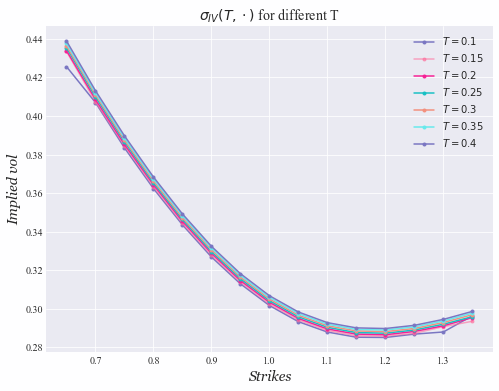

In [7]:
splits_vols = np.array_split(implied_vols, len(set(expiration)))
split_strikes = np.array_split(strike, len(set(expiration)))

fig, ax = plt.subplots(figsize=(8, 6))
for i in range(len(set(expiration))):
    ax.plot(split_strikes[i], splits_vols[i], label="$T={}$".format(expiration[i * len(split_strikes[0])]), marker = ".")

ax.set_title("$\sigma_{IV}(T, \cdot)$ for different T", fontsize=14)     
ax.set_xlabel("Strikes", fontname = "Georgia", style="italic", fontsize = 14)
ax.set_ylabel("Implied vol", fontname="Georgia", style="italic", fontsize=14) 
ax.set_axisbelow(True)
plt.grid(True)
ax.legend()
plt.show()

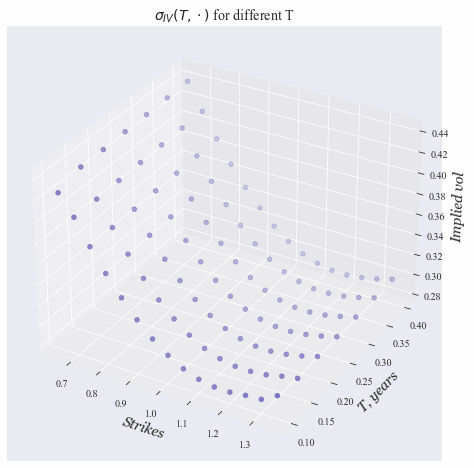

In [8]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d') 

ax.scatter(strike, expiration, implied_vols) 
ax.set_title("$\sigma_{IV}(T, \cdot)$ for different T", fontsize=14)     
ax.set_xlabel("Strikes", fontname = "Georgia", style="italic", fontsize=14)
ax.set_ylabel("T, years", fontname="Georgia", style="italic", fontsize=14) 
ax.set_zlabel("Implied vol", fontname="Georgia", style="italic", fontsize=14)
plt.rc('grid', linestyle = ":", color = '#B5B5B5')
ax.set_axisbelow(True)
plt.grid(True)
plt.show()

In [9]:
from scipy.interpolate import SmoothBivariateSpline

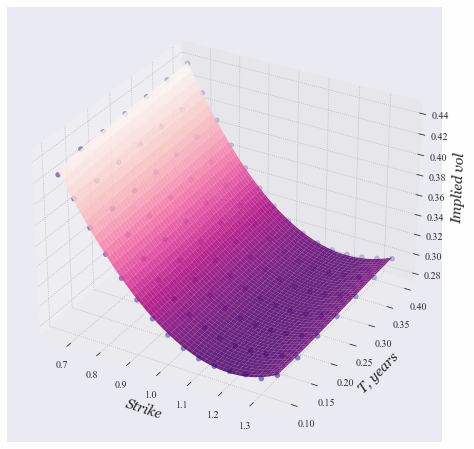

In [10]:
interpol = SmoothBivariateSpline(strike, expiration, implied_vols)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

x = np.linspace(min(strike), max(strike), 100)
y = np.linspace(expiration[0], expiration[-1], 100)
x, y = np.meshgrid(x, y)

z = interpol(x, y, grid=False)
                
plt.rc('grid', linestyle = ":", color = '#B5B5B5')
ax.set_axisbelow(True)
plt.grid(True)
                
ax.set_xlabel('Strike', fontname="Georgia", style="italic", fontsize=14) 
ax.set_ylabel('T, years', fontname="Georgia", style="italic", fontsize=14)  
ax.set_zlabel('Implied vol', fontname="Georgia", style="italic", fontsize=14)  

ax.scatter(strike, expiration, implied_vols) 
ax.plot_surface(x, y, z, cmap=plt.cm.RdPu_r, alpha=0.85)

plt.show()

In [11]:
import plotly.graph_objects as go
from scipy.interpolate import griddata, RectBivariateSpline, interp1d, SmoothBivariateSpline

In [12]:
fig = go.Figure()

fig.add_trace(go.Surface(z=np.vectorize(interpol)(x, y), x = x, y = y, colorscale='RdPu_r'))
fig.update_layout(scene=dict(
                    xaxis_title='Strike',
                    yaxis_title='T, years',
                    zaxis_title='Implied vol'),
                    title='Interactive implied volatility surface')

fig.show()

**2**. Write a function which evaluates a Dupire local volatility at given point, i.e. a function $(t, s) \to \sigma_{Dup}(t, s)$. Please note that it should return an "adequate" value for any input point $(t, s)$ from the considered ranges of strikes and times to expiration. Plot the obtained local volatility surface for a given grid of strikes and times to expiration. 

$$ \sigma_{Dup}(T, K) = \sqrt{\dfrac{\frac{\partial w}{\partial T}}{1 - \frac{y}{w} \frac{\partial w}{\partial y} + \frac{1}{4} ( -\frac{1}{4} - \frac{1}{w} + \frac{y^2}{w^2}) (\frac{\partial w}{\partial y})^2 + \frac{1}{2} \frac{\partial^2 w}{\partial y^2}}},$$


where 
$w(K, T) = \sigma^{2}_{IV}(K, T) \cdot T$ is implied variance and $y = \log(K / F_T)$ is forward log-moneyness. 

In [13]:
w = implied_vols**2 * expiration
y = np.log(strike / (np.exp(r * expiration) * s))
variance_splined = SmoothBivariateSpline(expiration, y, w)

In [14]:
def local_volatility(k: np.array, t: np.array) -> np.array:
    
    dw_dt = variance_splined.partial_derivative(dx=1, dy=0)
    dw_dy = variance_splined.partial_derivative(dx=0, dy=1)
    d2w_dy2 = variance_splined.partial_derivative(dx=0, dy=2)
    
    t[t > max(expiration)] = max(expiration)
    t[t < min(expiration)] = min(expiration)
    k[k > max(strike)] =  max(strike)
    k[k < min(strike)] = min(strike)
    
    y = np.log(k / (np.exp(r * t) * s))
    w = variance_splined(t, y, grid=False)
    
    local_vol_squared = dw_dt(t, y, grid=False) / (1 - y /w * dw_dy(t, y, grid=False) + 0.25 *(-0.25 - 1 / w + y**2 / w**2)\
                                                  * (dw_dy(t, y, grid=False))**2 + 0.5 * d2w_dy2(t, y, grid=False))
    return np.sqrt(local_vol_squared)

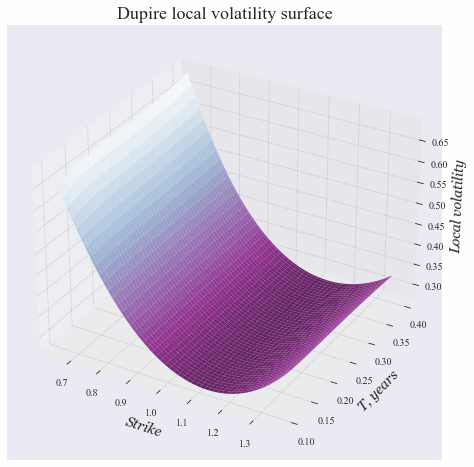

In [15]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

x_dupire = np.linspace(min(strike), max(strike), 100)
y_dupire = np.linspace(expiration[0], expiration[-1], 100)
x_dupire, y_dupire = np.meshgrid(x_dupire, y_dupire)

z_dupire = local_volatility(x_dupire, y_dupire)
ax.plot_surface(x_dupire, y_dupire, z_dupire, cmap=plt.cm.BuPu_r, alpha=0.85)
                
plt.rc('grid', linestyle = ":", color = '#B5B5B5')
ax.set_axisbelow(True)
plt.grid(True)

ax.set_title('Dupire local volatility surface', fontsize=18)
ax.set_xlabel('Strike', fontname="Georgia", style="italic", fontsize=14) 
ax.set_ylabel('T, years', fontname="Georgia", style="italic", fontsize=14) 
ax.set_zlabel('Local volatility', fontname="Georgia", style="italic", fontsize=14) 

plt.show()

In [16]:
fig = go.Figure()

fig.add_trace(go.Surface(z=z_dupire, x = x_dupire, y = y_dupire, colorscale='BuPu_r'))
fig.update_layout(scene=dict(
                    xaxis_title='Strike',
                    yaxis_title='T, years',
                    zaxis_title='Local Volatility, %'),
                    title='Interactive Dupire local volatility surface')
fig.show()

**3**. Implement a Monte-Carlo simulation calculator and price an option with time to expiration $T = 0.25$ for the range of strikes $K = \{ 0.6, 0.7, 0.8, \dots, 1.4\}$. Your calculator should return a range of prices $\{ V(T, K_i)\}$ and implied volatilites $\sigma_{IV}(T, K_i)$ (for each strike $K_i$), with an absolute error not greater than $1\%$ in implied vols for every (almost every) strike $K_i$. Plot on one graph the prices obtained using Monte Carlo and the prices from the file. Also, plot on other graph the implied vols obtained using Monte Carlo and the implied vols obtained in question (1).

In [17]:
s = 1.0    # spot price S_0
r = 0.0   # zero interest rate

In [18]:
strikes = np.linspace(0.6, 1.4, 9) # strikes
T = 0.25 # maturity
paths = 1000  # number of Monte-Carlo paths
steps = 10 # number of time steps

$$dS_t =S_t \sigma(t, S_t) dW_t, \quad S_0 = s,$$

The standrad *Euler* discretization scheme:

$$S_{t_{i + 1}} = S_{t_i} + \sigma_{Dup}(t_i, S_{t_i}) \Delta W_{t_i}.$$

However, direct usage of such scheme may lead to negative values of the prices $S_t$. For that reason, you may apply the Euler scheme to $\log(S_{t_i})$ and then finally put $S_{t_i} = e^{X_{t_i}}$. From Ito's formula, 

$$X_{t_{i + 1}} = X_{t_i} - \frac{1}{2} \sigma^2_{Dup}(t_i, e^{X_{t_i}}) \Delta t_i+ \sigma_{Dup}(t_i, e^{X_{t_i}}) \Delta W_{t_i}.$$

In [19]:
dt = T / steps 

In [20]:
def Monte_Carlo(mc_paths, mc_steps):
    mc_call_prices = np.zeros((len(strikes), mc_paths))
    mc_implied_vols = np.zeros((len(strikes), mc_paths))
    for i in range(len(strikes)):
        for j in range(mc_paths):
            X = np.zeros(mc_steps + 1)
            X[0] = np.log(s)
            for t_i in range(mc_steps):
                sigma_dupire = local_volatility(np.array([np.exp(X[t_i])]), np.array([t_i*dt]))
                dW = np.random.normal(0, 1)
                X[t_i + 1] = X[t_i] - 0.5 * sigma_dupire**2 * dt + sigma_dupire * np.sqrt(dt) * dW
            mc_call_prices[i, j] = np.exp(-r * T) * np.maximum(np.exp(X[-1]) - strikes[i], 0)
            mc_implied_vols[i, j] = implied_volatility(mc_call_prices[i, j], np.exp(X[-1]), strikes[i], r, T, "c")
    return mc_call_prices, mc_implied_vols

In [21]:
mc_call_prices, mc_implied_vols = Monte_Carlo(paths, steps)

In [22]:
mc_calls = np.zeros(len(strikes))
mc_ivs = np.zeros(len(strikes))
for i in range(len(strikes)):
    mc_calls[i] = np.mean(mc_call_prices[i])       
    mc_ivs[i] = np.mean(mc_implied_vols[i])  

In [23]:
f = open("data.txt", "r")
data = f.readlines()
f.close()

file_strike = np.array([])
file_call_price = np.array([])

for string in data[1:]:
    arr = string.split()
    arr = "".join(arr).split(",")
    if float(arr[0]) == 0.25:
        file_strike = np.append(file_strike, float(arr[1]))
        file_call_price = np.append(file_call_price, float(arr[2]))

In [24]:
print(file_strike, file_call_price)

[0.65 0.7  0.75 0.8  0.85 0.9  0.95 1.   1.05 1.1  1.15 1.2  1.25 1.3
 1.35] [0.35157 0.30283 0.25502 0.20874 0.1649  0.12469 0.08952 0.06063 0.03869
 0.02338 0.01354 0.00764 0.00427 0.00239 0.00135]


In [25]:
file_implied_vols = np.array([])

for i in range(file_call_price.size):
    res = implied_volatility(file_call_price[i], 
                                np.exp(r * T) * s, 
                                file_strike[i],
                                r,
                                T,
                                "c",
                                )
    file_implied_vols = np.append(file_implied_vols, res)

In [26]:
file_implied_vols

array([0.43540938, 0.4099154 , 0.3865682 , 0.36529958, 0.34634425,
       0.32967403, 0.31560455, 0.30424685, 0.29587701, 0.29042066,
       0.28769158, 0.2873738 , 0.28901436, 0.29201241, 0.29592736])

In [27]:
strikes_grid = np.linspace(0.6, 1.4, 9)

In [28]:
def cubic_vol_interpolator(strikes: np.ndarray, volatilities: np.ndarray):
    return PchipInterpolator(x=np.log(strikes), y=volatilities, extrapolate=True)

In [29]:
vol_cubic = cubic_vol_interpolator(strikes=file_strike, volatilities=file_implied_vols)

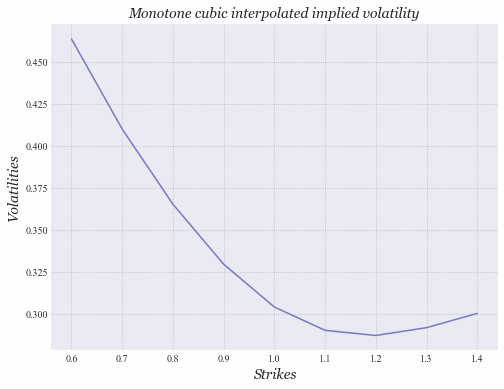

In [30]:
plt.figure(figsize=(8, 6))
plt.plot(strikes_grid, vol_cubic(np.log(strikes_grid)))
plt.title("Monotone cubic interpolated implied volatility", fontname = "Georgia", style="italic", fontsize = 14)
plt.xlabel("Strikes", fontname = "Georgia", style="italic", fontsize = 14)
plt.ylabel("Volatilities", fontname = "Georgia", style="italic", fontsize = 14)
plt.show()

In [31]:
vol_cubic(np.log(strikes_grid))

array([0.46343664, 0.4099154 , 0.36529958, 0.32967403, 0.30424685,
       0.29042066, 0.2873738 , 0.29201241, 0.30050128])

In [32]:
f = interpolate.interp1d(file_strike, file_implied_vols, fill_value = "extrapolate")
print(strikes_grid, f(strikes_grid))

[0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4] [0.46090335 0.4099154  0.36529958 0.32967403 0.30424685 0.29042066
 0.2873738  0.29201241 0.29984231]


In [33]:
def Black_Scholes(r, S, K, T, sigma, type = "call"):
    
    "Calculate BS price of call/put option"
    
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    call_price = S * norm.cdf(d1) - K * np.exp(- r * T) * norm.cdf(d2)

    if type == "call":
        return call_price
    elif type == "put":
        return call_price + K * np.exp(- r * T) - S

In [34]:
plot_file_call_price = file_call_price[1::2]
vol_first, vol_last = f(strikes_grid)[0], f(strikes_grid)[-1]
#print(plot_file_call_price, strikes_grid[0], strikes_grid[-1])

price_first = Black_Scholes(r, s, strikes_grid[0], T, vol_first, type = "call")
price_last = Black_Scholes(r, s, strikes_grid[-1], T, vol_last, type = "call")

plot_file_call_price = np.insert(plot_file_call_price, 0, price_first)
plot_file_call_price = np.append(plot_file_call_price, price_last)

print(strikes, plot_file_call_price)

[0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4] [0.40082751 0.30283    0.20874    0.12469    0.06063    0.02338
 0.00764    0.00239    0.00076182]


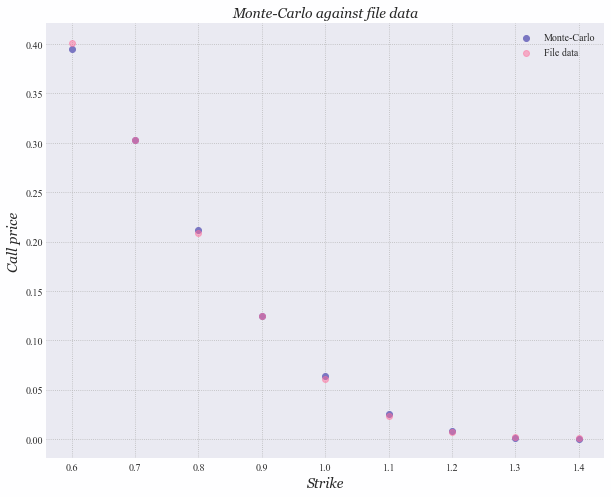

In [35]:
fig = plt.figure(figsize=(10, 8))
plt.scatter(strikes, mc_calls, color = '#7A76C2', label='Monte-Carlo')
plt.scatter(strikes, plot_file_call_price, color = '#ff6e9c98', alpha=0.5, label='File data')

plt.xlabel('Strike', fontname="Georgia", style="italic", fontsize=14)
plt.ylabel('Call price', fontname="Georgia", style="italic", fontsize=14)
plt.title('Monte-Carlo against file data', fontname="Georgia", style="italic", fontsize=14)
plt.legend()
plt.show()

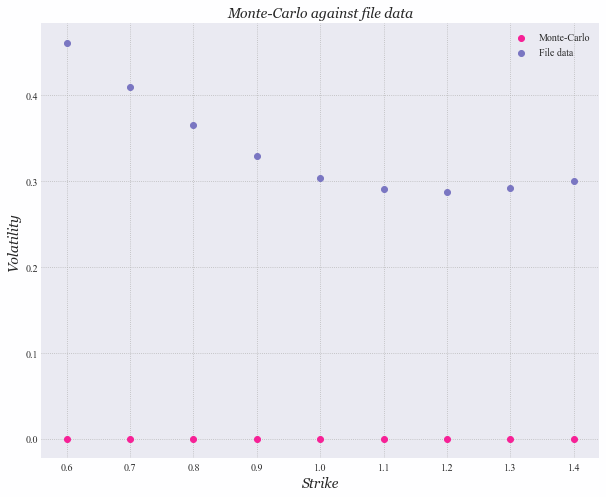

In [36]:
fig = plt.figure(figsize=(10, 8))
plt.scatter(strikes, mc_ivs, color = '#f62196', label='Monte-Carlo')
plt.scatter(strikes, f(strikes_grid), color = '#7A76C2', label='File data')

plt.xlabel('Strike', fontname="Georgia", style="italic", fontsize=14)
plt.ylabel('Volatility', fontname="Georgia", style="italic", fontsize=14)
plt.title('Monte-Carlo against file data', fontname="Georgia", style="italic", fontsize=14)
plt.legend()
plt.show()